# 6d reconstruction scan

In [1]:
import os
import sys
sys.path.append("../")

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


## define the diagnostic

In [2]:
from measurement import get_DYG14, get_DYG15, set_camera, set_background

save_image_location = "/home/awa/awa_data/01-16_6DReconstruction/reconstruction_scan"
DYG14 = get_DYG14()
DYG15 = get_DYG15()

DYG14.save_image_location = save_image_location
DYG15.save_image_location = save_image_location
DYG14.background_file = save_image_location + "/DYG14_background.npy"
DYG15.background_file = save_image_location + "/DYG15_background.npy"


setting camera DYG15


CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 17:28:29.249602069
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 17:28:29.249768757
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 17:28:29.249884772
................................................................

192.168.2.139
ip address already set
starting acquisition
displaying image
fitting image


{'Cx': nan,
 'Cy': nan,
 'Sx': nan,
 'Sy': nan,
 'bb_penalty': 89.32227877400243,
 'total_intensity': 61726044.800000004,
 'log10_total_intensity': 7.790468449710239,
 'AWAVXI11ICT:Ch4': 2.5090972973395617e-09}

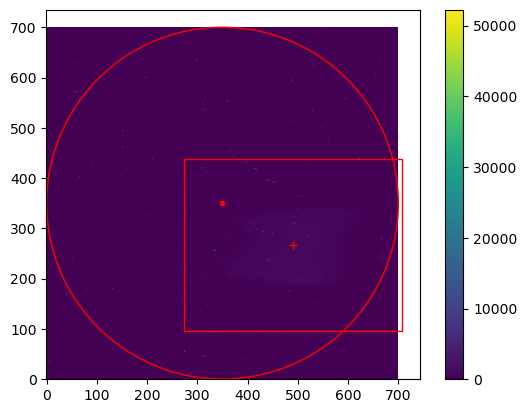

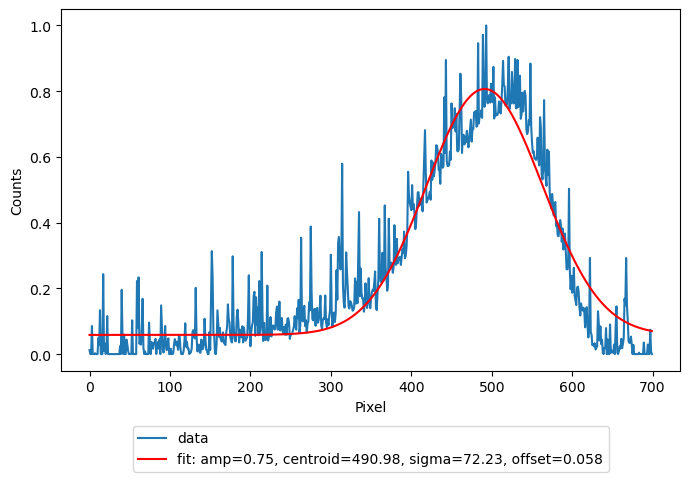

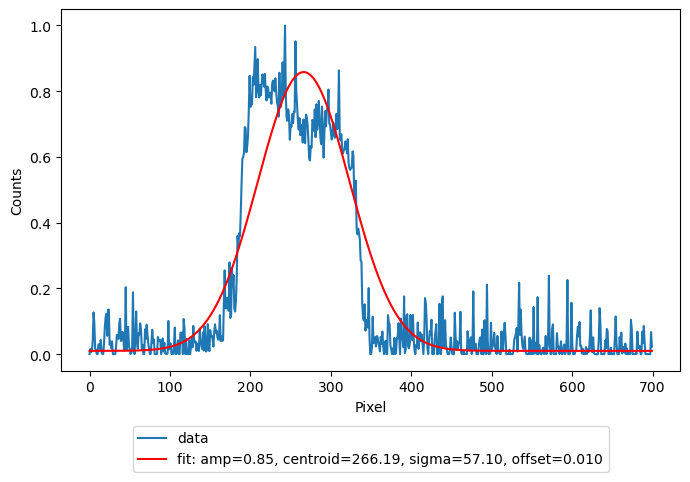

In [3]:
from measurement import get_DYG14, get_DYG15, set_camera, set_background

set_camera(DYG15)
DYG15.target_charge = None
DYG15.test_measurement()

In [4]:
#set_background(DYG14)
# set the dipole on for this part!
#set_background(DYG15)

### Define the evaluator

In [5]:
from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

def evaluate_function(inputs: dict, diagnostic, testing=False) -> dict:
    # caput values
    if not testing:
        for name, val in inputs.items():
            caput(name, val)
            print(name, val)

    # wait for changes to occur
    time.sleep(2)
    print(time.time())
    results = diagnostic.measure_beamsize(20, fit_image=False, **inputs)

    return results | inputs

evaluator = Evaluator(function=evaluate_function)

### Set up scan

In [6]:
# quad strength pv values
import numpy as np
import pandas as pd
import yaml
import json

x = np.linspace(-0.4,0.4,9)
quad_pv_name = "AWA:Bira3Ctrl:Ch10"
tdc_pv_name = "pi:QBCR1:Ch7:EnablePulse"
dipole_pv_name = "AWA:Bira4Ctrl:Ch01"
tdc_vals = {"OFF":0, "ON":1} # off/on values
dipole_vals = {"OFF":0, "ON":-3.68} # off/on vals

DYG14.target_charge = 1.5e-9
DYG15.target_charge = 1.5e-9
DYG14.charge_atol = 0.5e-9
DYG15.charge_atol = 0.5e-9
DYG14.wait_time = 0.6
DYG15.wait_time = 0.6


def do_quad_scan(k, pv_dict, diagnostic, testing=False):
    q_scan_data = []
    print("doing quad scan")
    for ele in k:
        # add tcav/dipole settings to quad settings
        total_pvs = pv_dict | {quad_pv_name:ele}
        print(total_pvs)

        # do measurement
        result = evaluate_function(total_pvs, diagnostic, testing)
        q_scan_data += [result]

    return q_scan_data

data = []

# do quad scan with dipole off
set_camera(DYG14)
# set dipole
print("setting dipole")
caput(dipole_pv_name, dipole_vals["OFF"])
time.sleep(15)
print("dipole finished moving")
for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["OFF"]},
        DYG14,
    )
    data = data + q_scan_results

    pd_data = pd.DataFrame(data)

    # save dataframe to file
    with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
        yaml.dump(json.loads(pd_data.to_json(orient="records"))
    , outfile, default_flow_style=False)





# do quad scan with dipole on
set_camera(DYG15)
# set dipole
print("setting dipole")
caput(dipole_pv_name, dipole_vals["OFF"])
time.sleep(15)
print("dipole finished moving")

for tdc_state in ["OFF","ON"]:
    q_scan_results = do_quad_scan(
        x,
        {tdc_pv_name: tdc_vals[tdc_state], dipole_pv_name: dipole_vals["ON"]},
        DYG15,
    )
    data = data + q_scan_results

    pd_data = pd.DataFrame(data)

    # save dataframe to file
    with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
        yaml.dump(json.loads(pd_data.to_json(orient="records"))
    , outfile, default_flow_style=False)

pd_data = pd.DataFrame(data)

# save dataframe to file
with open(os.path.join(save_image_location, 'data.yml'), 'w') as outfile:
    yaml.dump(json.loads(pd_data.to_json(orient="records"))
, outfile, default_flow_style=False)

setting camera DYG14
192.168.2.139
setting IP address 192.168.2.111
setting gain


CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:cam1:Gain", Connecting to: awa5:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 17:28:37.706091864
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:cam1:Gain", Connecting to: awa5:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Tue Jan 16 2024 17:28:37.706497031
..................................................................


starting acquisition
setting dipole
dipole finished moving
doing quad scan
{'pi:QBCR1:Ch7:EnablePulse': 0, 'AWA:Bira4Ctrl:Ch01': 0, 'AWA:Bira3Ctrl:Ch10': -0.4}
pi:QBCR1:Ch7:EnablePulse 0
AWA:Bira4Ctrl:Ch01 0
AWA:Bira3Ctrl:Ch10 -0.4
1705447738.770091
measured charge:  1.359995412102899e-09
measured charge:  1.4550835615854755e-09
measured charge:  1.1460182568097683e-09
measured charge:  2.3693829925383545e-09
charge error 8.7e-10 outside atol 5e-10
measured charge:  2.195647908690563e-09
charge error 7e-10 outside atol 5e-10
measured charge:  1.634254621246643e-09
measured charge:  1.3097351506397303e-09
measured charge:  2.04708978637987e-09
charge error 5.5e-10 outside atol 5e-10
measured charge:  1.7493899578739334e-09
measured charge:  1.4911108605313803e-09
measured charge:  2.8783113682886355e-09
charge error 1.4e-09 outside atol 5e-10
measured charge:  1.5842177067022959e-09
measured charge:  1.7415187801720297e-09
measured charge:  1.4112967583970771e-09
measured charge:  1.489

In [7]:
import yaml
import json

